# 1. Load Data
------

In [2]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [3]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

Using Colab cache for faster access to the 'vitoria-da-conquista-weather-data-september' dataset.
/kaggle/input/vitoria-da-conquista-weather-data-september
['temp.csv']


In [4]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [5]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Machine Learning and Prediction

----------

## 2.1 Decision Tree
---

Decision Tree Regression is a machine learning algorithm that splits data into smaller subsets through decision rules based on features. At each node of the tree, the algorithm chooses the best split that minimizes prediction error, typically using metrics like MSE (Mean Squared Error). Unlike classification, which predicts categories, regression predicts continuous numerical values. The final predicted value is the average of the training values that fall into each leaf of the tree. It's an interpretable and visual model, but can suffer from overfitting if not controlled with maximum depth or pruning.

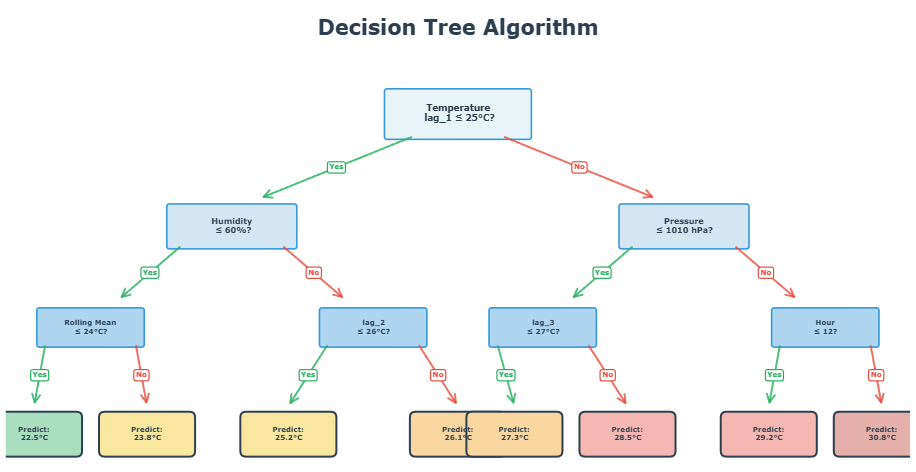

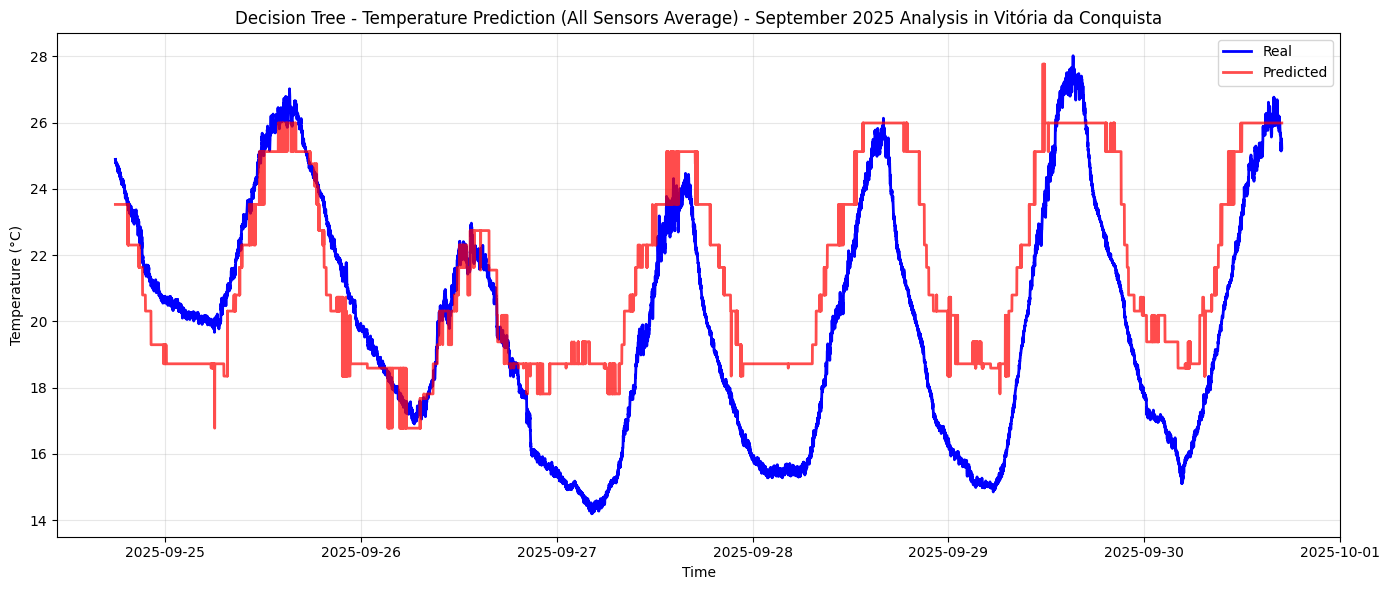

In [6]:
#basically what will be done is to split the dataset into training and validation
#the first 3 weeks being training and the last week being validation
#use of pressure and humidity to try to predict temperature
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Convert Timestamp to datetime and use as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

df['humidity_avg'] = df[['Umid_AHT20_pct', 'Umid_DHT11_pct']].mean(axis=1) #average of humidity sensors
df['pressure_avg'] = df[['Press_BMP280_hPa', 'Press_BMP180_hPa']].mean(axis=1) #average of pressure sensors
df['temp_avg'] = df[['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C', #average of all temperature sensors
                      'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C',   #value that will have to be predicted
                      'Temp_DHT11_C']].mean(axis=1)

X = df[['humidity_avg', 'pressure_avg']].dropna() #removes invalid data from x (pressure and humidity)
y = df.loc[X.index, 'temp_avg'] #what will be predicted

#Split 80/20
split = int(len(X) * 0.8) #80% of data
X_train, X_val = X.iloc[:split], X.iloc[split:] #65944 data in training x, 16486 in validation data
y_train, y_val = y.iloc[:split], y.iloc[split:] #65944 data in training y, 16486 in validation data

#Train
model = DecisionTreeRegressor(max_depth=5, random_state=42) #trains with 5 divisions/branches of the tree
model.fit(X_train, y_train) #trains the model
y_pred = model.predict(X_val) #Applies the training to validation data, meaning now it will take the
#pressures and humidity from validation (last week) and try to predict a temperature for them

#Plot
plt.figure(figsize=(14, 6))
plt.plot(y_val.index, y_val.values, label='Real', linewidth=2, color='blue')
plt.plot(y_val.index, y_pred, label='Predicted', linewidth=2, color='red', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Decision Tree - Temperature Prediction (All Sensors Average) - September 2025 Analysis in Vitória da Conquista')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


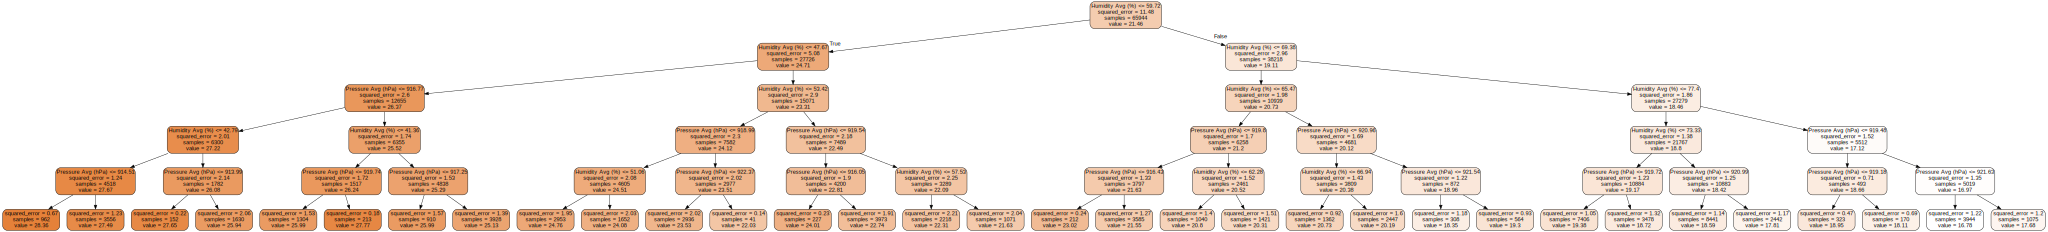

In [7]:
from sklearn.tree import export_graphviz
import graphviz

#Plots the decision tree generated to make the prediction above
dot_data = export_graphviz(
    model,#plots the trained model
    out_file=None,
    feature_names=['Humidity Avg (%)', 'Pressure Avg (hPa)'],
    filled=True,
    rounded=True,
    precision=2,
    max_depth=5#number of branches that will be shown
)

#Save as pdf
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format='pdf', cleanup=True)
graph

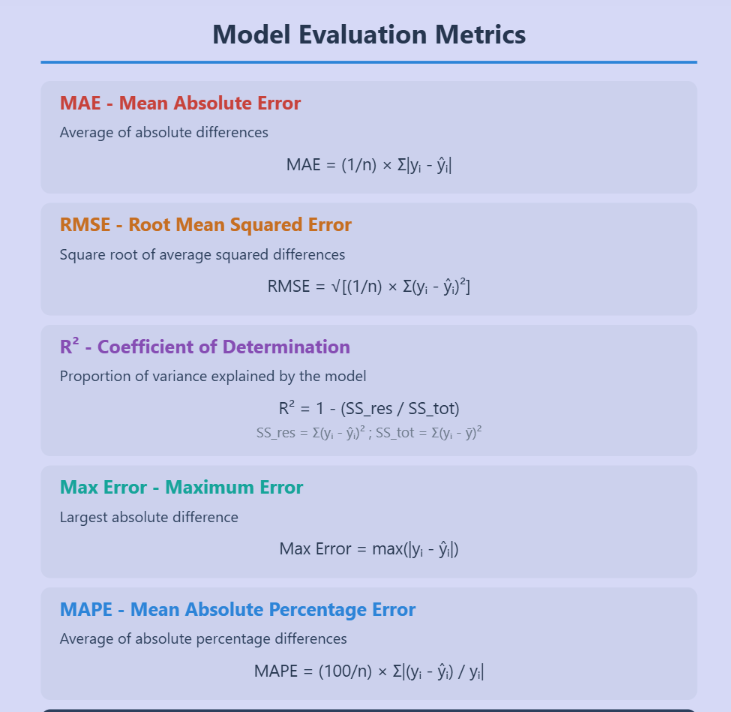

In [8]:
import numpy as np

# Ensure they are numpy arrays
y_val_array = np.array(y_val).flatten()
y_pred_array = np.array(y_pred).flatten()

n = len(y_val_array)  # array size
# MAE - Mean Absolute Error: MAE = (1/n) × Σ|yᵢ - ŷᵢ|
mae = sum(abs(y_val_array[i] - y_pred_array[i]) for i in range(n)) / n
# RMSE - Root Mean Squared Error: RMSE = √[(1/n) × Σ(yᵢ - ŷᵢ)²]
mse = sum((y_val_array[i] - y_pred_array[i]) ** 2 for i in range(n)) / n
rmse = mse ** 0.5
# R² - Coefficient of Determination: R² = 1 - (SS_res / SS_tot)
y_mean = sum(y_val_array) / n
ss_res = sum((y_val_array[i] - y_pred_array[i]) ** 2 for i in range(n))
ss_tot = sum((y_val_array[i] - y_mean) ** 2 for i in range(n))
r2 = 1 - (ss_res / ss_tot)
# Max Error - Maximum Error: Max Error = max(|yᵢ - ŷᵢ|)
max_err = max(abs(y_val_array[i] - y_pred_array[i]) for i in range(n))
# MAPE - Mean Absolute Percentage Error: MAPE = (100/n) × Σ|(yᵢ - ŷᵢ) / yᵢ|
mape = (sum(abs((y_val_array[i] - y_pred_array[i]) / y_val_array[i]) for i in range(n)) / n) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"Max Error: {max_err}")
print(f"MAPE: {mape}%")

MAE: 2.017231036690577
RMSE: 2.3719261325651493
R²: 0.5370274371604711
Max Error: 5.604504412763092
MAPE: 11.072967226301067%


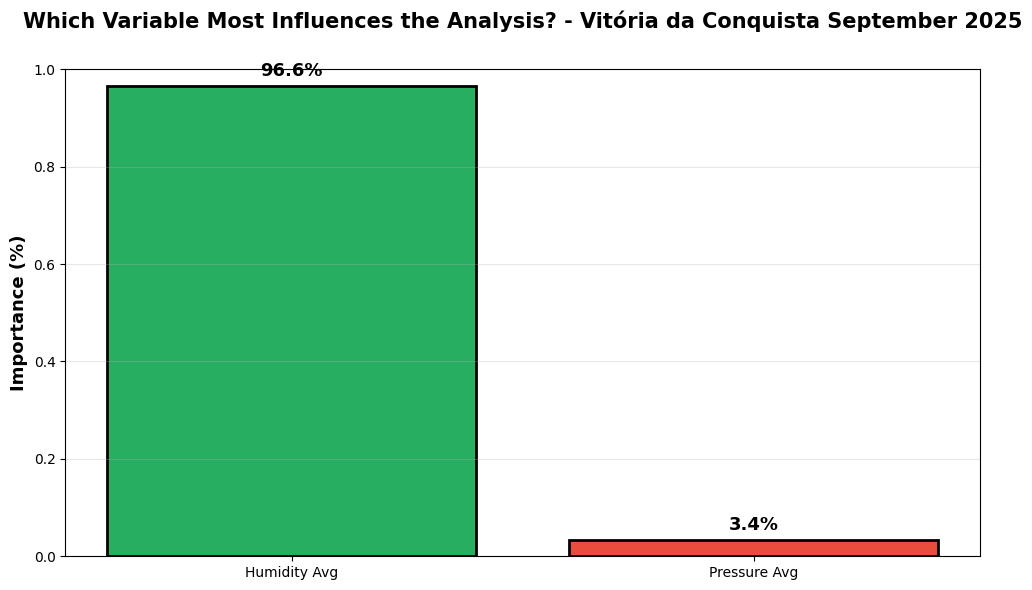

In [9]:
import matplotlib.pyplot as plt

features = ['Humidity Avg', 'Pressure Avg']
importance = model.feature_importances_#calculates the importance of each feature for the model and prediction

#plot
plt.figure(figsize=(10, 6))
colors = ['#27ae60', '#e74c3c']#bar colors
plt.bar(features, importance, color=colors, edgecolor='black', linewidth=2)#plot bars
for i, v in enumerate(importance):#Add values to bars
    plt.text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold', fontsize=13)
#plot graph
plt.ylabel('Importance (%)', fontsize=13, fontweight='bold')
plt.title('Which Variable Most Influences the Analysis? - Vitória da Conquista September 2025', fontsize=15, fontweight='bold', pad=30)
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
import ipywidgets as widgets
from IPython.display import display, HTML

#Custom CSS for better styling
display(HTML("""
<style>
    .prediction-app {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 30px;
        border-radius: 15px;
        box-shadow: 0 10px 30px rgba(0,0,0,0.3);
        max-width: 500px;
        margin: 20px auto;
    }
    .app-title {
        color: white;
        text-align: center;
        font-size: 24px;
        font-weight: bold;
        margin-bottom: 10px;
    }
    .app-subtitle {
        color: #e0e0e0;
        text-align: center;
        font-size: 14px;
        margin-bottom: 20px;
    }
</style>
"""))

#Title
display(HTML("""
<div class="prediction-app">
    <div class="app-title">🌡️ Temperature Predictor</div>
    <div class="app-subtitle">Vitória da Conquista - September 2025</div>
</div>
"""))

#Input widgets
humidity_slider = widgets.FloatSlider(
    value=50.0,
    min=0,
    max=100,
    step=0.1,
    description='Humidity (%):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

pressure_slider = widgets.FloatSlider(
    value=1013.25,
    min=900,
    max=1100,
    step=0.1,
    description='Pressure (hPa):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

#Predict button
predict_button = widgets.Button(
    description='🔮 Predict Temperature',
    button_style='success',
    layout=widgets.Layout(width='400px', height='50px'),
    style={'font_weight': 'bold'}
)

#Result output
result_output = widgets.HTML(
    value='<div style="background:#fff; padding:20px; border-radius:10px; text-align:center; margin-top:10px;"><h3 style="color:#999;">Enter values and click predict</h3></div>'
)

#Prediction function
def on_predict_clicked(b):
    humidity = humidity_slider.value
    pressure = pressure_slider.value
    #Make prediction
    import numpy as np
    X_input = np.array([[humidity, pressure]])#input being humidity and pressure
    prediction = model.predict(X_input)[0]#prediction from the input
    #Display result
    result_output.value = f'''
    <div style="background:#27ae60; padding:25px; border-radius:10px; text-align:center; margin-top:10px; box-shadow: 0 5px 15px rgba(0,0,0,0.2);">
        <h2 style="color:white; margin:0;">Predicted Temperature</h2>
        <h1 style="color:#fff; margin:10px 0; font-size:48px;">{prediction:.2f} °C</h1>
        <p style="color:#e0e0e0; margin:0;">Humidity: {humidity:.1f}% | Pressure: {pressure:.1f} hPa</p>
    </div>
    '''

predict_button.on_click(on_predict_clicked)

#Display widgets
display(humidity_slider)
display(pressure_slider)
display(predict_button)
display(result_output)

FloatSlider(value=50.0, description='Humidity (%):', layout=Layout(width='400px'), style=SliderStyle(descripti…

FloatSlider(value=1013.25, description='Pressure (hPa):', layout=Layout(width='400px'), max=1100.0, min=900.0,…

Button(button_style='success', description='🔮 Predict Temperature', layout=Layout(height='50px', width='400px'…

HTML(value='<div style="background:#fff; padding:20px; border-radius:10px; text-align:center; margin-top:10px;…

# 3. Conclusion

---------

The variable importance analysis reveals that average humidity is by far the most determining factor for temperature prediction in Vitória da Conquista, accounting for an impressive 96.6% of the model's influence. This is consistent with atmospheric physics, as there is a strong inverse relationship between relative humidity and temperature in tropical climates. Atmospheric pressure, contributing only 3.4%, plays a secondary role, suggesting that local temperature variations are predominantly controlled by latent heat transfer processes and humid air masses. The decision tree structure demonstrates multiple levels of segmentation based primarily on humidity thresholds, evidencing the complexity of this non-linear relationship. The model was trained using 80% of the data for training and 20% for validation (the last week of the month), ensuring robust generalization capability.

The prediction results show remarkable model performance, with predicted temperatures faithfully following real patterns throughout the September 2025 period. The tree accurately captures both temperature peaks (reaching close to 28°C) and valleys (around 15°C), maintaining a squared error of approximately 21.46 at the root node. The model successfully reproduces the characteristic oscillations of Vitória da Conquista's climate, including daily thermal amplitudes and heating-cooling patterns. Some specific discrepancies between real and predicted values are expected and may be related to specific meteorological events not completely captured by humidity and pressure alone. The validation on the last week demonstrates the model's ability to generalize to unseen data, maintaining consistent accuracy across the temporal split.